# Mid-Sagittal plane algorithm

### Import relevant packages

In [155]:
import joblib
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import center_of_mass
from scipy.optimize import minimize
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator
from joblib import Parallel, delayed, dump, load
from matplotlib.widgets import Slider
import ipywidgets as widgets
from matplotlib.lines import Line2D
import time
from scipy import ndimage
import json
import skimage
from scipy.spatial import ConvexHull, distance
import seaborn as sns
import pickle
import os
import gzip
from scipy.spatial.transform import Rotation as R
import imageio
from nibabel.orientations import aff2axcodes

## Data Reading

In [156]:
def load_nifti_file(file_path):
    """
    Load + reorient a NIfTI file so that:
      axis 0 = coronal slices (world Y)
      axis 1 = sagittal slices (world X)
      axis 2 = axial   slices (world Z)

    Returns
    -------
    img_data : ndarray, shape (n_coronal, n_sagittal, n_axial)
    voxel_size : tuple, len=3, reordered to match the new axes
    """
    nifti_img = nib.load(file_path)
    data = nifti_img.get_fdata()
    voxel_size = np.array(nifti_img.header.get_zooms())

    # determine which data-axis is world-X, world-Y, world-Z
    codes = aff2axcodes(nifti_img.affine)  
    code2world = {'L':0,'R':0,'P':1,'A':1,'I':2,'S':2}
    world_of_axis = [code2world[c] for c in codes]  
    # find data-axis indices for each world axis
    idx_x = world_of_axis.index(0)  # sagittal
    idx_y = world_of_axis.index(1)  # coronal
    idx_z = world_of_axis.index(2)  # axial

    # we want new_data[ coronal, sagittal, axial ]
    new_order = [idx_y, idx_x, idx_z]
    data = np.transpose(data, new_order)
    voxel_size = np.array(tuple(voxel_size[new_order]))

    return data, voxel_size

def open_gzip_file(gzip_file_path):
    """
    Open a gzip file and return its content.

    Parameters:
    gzip_file_path (str): The path to the gzip file.

    Returns:
    bytes: The content of the gzip file.
    """
    try:
        with gzip.open(gzip_file_path, 'rb') as f_in:
            file_content = f_in.read()
        return file_content
    except Exception as e:
        print(f'Error opening {gzip_file_path}: {e}')
        return None
    
def get_image_and_voxel_size_from_gzip(gzip_file_path):
    """
    Get the image array and voxel size from a gzipped NIfTI file.

    Parameters:
    gzip_file_path (str): Path to the gzipped NIfTI file.

    Returns:
    tuple: The image array and voxel size.
    """

    file_content = open_gzip_file(gzip_file_path)
    if file_content is not None:
        with open('temp_nifti.nii', 'wb') as temp_file:
            temp_file.write(file_content)

        # 🔹 Debugging: Check if the file was actually written
        file_size = os.path.getsize('temp_nifti.nii')
        if file_size == 0:
            print(f"❌ Error: 'temp_nifti.nii' was written but is empty! ({gzip_file_path})")
            return None, None

        img_data, voxel_size = load_nifti_file('temp_nifti.nii')
        os.remove('temp_nifti.nii')  # Remove temp file after reading
        
        return img_data, voxel_size
    else:
        print(f"❌ Error: Failed to read file content from '{gzip_file_path}'")
        return None, None
    
def load_patient_structures(patient_folder: str, structure_names=None):
    """
    Searches the patient folder (recursively) for NIfTI files matching the
    specified structure names, loads each file, transposes the image array,
    and returns a mapping from structure name to (image_array, voxel_size).

    Parameters
    ----------
    patient_folder : str
        Path to the patient folder (numeric name).
    structure_names : list of str, optional
        List of expected structure names (without extension). Defaults to:
        ['Image', 'GTVp', 'Body', 'Mandible', 'Spinal Cord'].
    Returns
    -------
    dict
        Keys are structure names from structure_names that were found,
        values are tuples (img_array, voxel_size).
    """
    if structure_names is None:
        structure_names = ['Image', 'GTVp', 'Body', 'Mandible', 'Spinal Cord']

    struct_dict = {}
    for root, _, files in os.walk(patient_folder):
        for f in files:
            # Only NIfTI files
            if not (f.endswith('.nii.gz') or f.endswith('.nii')):
                continue

            name_part = f
            
            # Entferne Extension
            if name_part.endswith('.nii.gz'):
                base = name_part[:-7]
            else:
                base = name_part[:-4]

            # Vergleiche mit erwarteten Struktur-Namen (case-insensitive)
            for struct_name in structure_names:
                if base.lower() == struct_name.lower():
                    file_path = os.path.join(root, f)
                    try:
                        if f.endswith('.nii.gz'):
                            img, voxel_size = get_image_and_voxel_size_from_gzip(file_path)
                        else:
                            img, voxel_size = load_nifti_file(file_path)
                    except Exception as e:
                        logging.error(f"Error loading '{struct_name}' from {file_path}: {e}")
                        continue

                    if img is not None:
                        #img = np.transpose(img, (1, 0, 2))
                        struct_dict[struct_name] = (img, voxel_size)
                        print(f"Loaded '{struct_name}' from {file_path}")
                    break
    return struct_dict

## Image processing

In [157]:
def mask_via_threshold(ct_image, HU_range=(300, 1500)):
    
    bone_mask = np.zeros_like(ct_image)
    lower_bound, upper_bound = HU_range
    bone_mask[(ct_image >= lower_bound) & (ct_image <= upper_bound)] = 1

    return bone_mask

def crop_patient_volumes(image,
                         gtvp,
                         body=None,
                         mandibula=None,
                         spinalcord=None,
                         slice_axis=2,
                         slice_range=None):
    """
    Crop a set of 3D volumes along a given axis to the non-zero range of the GTVp mask,
    or to a user-specified slice_range.

    Parameters
    ----------
    image : ndarray
        Main image volume, shape (H, W, D).
    gtvp : ndarray
        GTVp mask (same shape as image).
    body : ndarray or None
        Body mask (same shape as image).
    mandibula : ndarray or None
        Mandible mask (same shape as image).
    spinalcord : ndarray or None
        Spinal cord mask (same shape as image).
    slice_axis : int, default=2
        Axis along which to crop (0=coronal, 1=sagittal, 2=axial).
    slice_range : tuple(int, int) or None
        If given, overrides the automatic [start, end] from gtvp mask.
        Interpreted as inclusive slice indices (start, end).

    Returns
    -------
    Cropped arrays in the same order:
      image_c, bone_ct_c, gtvp_c, body_c, mandibula_c, spinalcord_c
    """
    from scipy.ndimage import find_objects

    # 1) determine start/end from nonzero gtvp mask
    # find_objects returns slice objects for each nonzero region:
    slc = find_objects(gtvp.astype(bool))[0]
    start, end = slc[slice_axis].start, slc[slice_axis].stop - 1

    # 2) override if slice_range provided
    if slice_range is not None:
        start, end = slice_range

    # build index range (inclusive)
    idx = np.arange(start, end + 1)

    # 3) define helper to crop any array
    def _crop(arr):
        return np.take(arr, idx, axis=slice_axis)

    # 4) apply to each
    image_c    = _crop(image)
    gtvp_c     = _crop(gtvp)
    body_c     = _crop(body)     if body is not None     else None
    mandibula_c= _crop(mandibula) if mandibula is not None else None
    spinalcord_c=_crop(spinalcord) if spinalcord is not None else None

    return image_c, gtvp_c, body_c, mandibula_c, spinalcord_c

def preprocess_bone_image(image,
                          HU_range,
                          body_mask=None,
                          fill_upper=10000):
    """
    Threshold and inpaint a CT volume to isolate bone and dental fillings.

    Parameters
    ----------
    image : ndarray
        3D CT volume (HU values).
    HU_range : tuple(int, int)
        Lower and upper thresholds for bone (e.g. (300, 1500)).
    body_mask : ndarray, optional
        3D binary mask of the body; voxels outside this are set to -1000 HU.
    fill_upper : int, default=10000
        Upper threshold for dental fillings mask.

    Returns
    -------
    proc_image : ndarray, dtype=int16
        Modified CT volume where voxels outside bone+fillings are set to -1000.
    bone_ct : ndarray, dtype=int16
        CT volume zeroed outside the bone mask plus inpainted fillings at HU_range[1].
    bone_mask : ndarray, dtype=uint16
        Binary mask (0/1) of bone voxels (HU_range).
    dental_mask : ndarray, dtype=uint16
        Binary mask (0/1) of dental filling voxels (>HU_range[1]).
    dental_ct : ndarray, dtype=int16
        Volume containing only dental filling voxels at constant HU=HU_range[1].
    """
    # ensure correct dtype
    proc_image = image.astype(np.int16)

    # zero-out everything outside body if provided
    if body_mask is not None:
        proc_image = np.where(body_mask == 1, proc_image, -1000)

    # bone mask and CT
    bone_mask = mask_via_threshold(proc_image, HU_range).astype(np.uint16)
    bone_ct = proc_image * bone_mask

    # dental fillings mask and CT inpaint
    dental_mask = mask_via_threshold(proc_image, (HU_range[1], fill_upper)).astype(np.uint16)
    dental_ct = 2000 * dental_mask

    # combine bone CT + dental inpaint, and remove fillings from original
    bone_ct = bone_ct + dental_ct
    proc_image = proc_image * (1 - dental_mask) + dental_ct

    return proc_image, bone_ct, bone_mask , dental_mask, dental_ct


## Interpolation

In [158]:
def get_cached_interpolator(output_dir,
                            image,
                            voxel_size,
                            filename='interpolator.joblib',
                            method='cubic'):
    """
    Load—or if missing, build and cache—a RegularGridInterpolator
    on the physical coordinate grid defined by voxel_size.

    Parameters
    ----------
    output_dir : str
        Directory in which to look for / save the cached interpolator.
    image : ndarray, shape (Ny, Nx, Nz)
        Reoriented volume data.
    voxel_size : sequence of 3 floats
        Physical spacing in mm along (Y, X, Z) axes.
    filename : str, optional
        Name of the .joblib file to load/save under output_dir.
    method : str, optional
        Interpolation method: ‘cubic’, ‘linear’, etc.

    Returns
    -------
    interpolator : RegularGridInterpolator
        Maps (y_mm, x_mm, z_mm) → image intensity.
    """
    os.makedirs(output_dir, exist_ok=True)
    interpolator_path = os.path.join(output_dir, filename)

    # build physical‐space sample grids
    Ny, Nx, Nz = image.shape
    grid_y = np.arange(Ny) * voxel_size[0]
    grid_x = np.arange(Nx) * voxel_size[1]
    grid_z = np.arange(Nz) * voxel_size[2]

    if os.path.exists(interpolator_path):
        interpolator = joblib.load(interpolator_path)
    else:
        start = time.time()
        interpolator = RegularGridInterpolator(
            (grid_y, grid_x, grid_z),
            image,
            method=method,
            bounds_error=False,
            fill_value=None
        )
        elapsed = time.time() - start
        print(f"Cubic interpolator built in {elapsed:.2f}s and cached to\n  {interpolator_path}")
        joblib.dump(interpolator, interpolator_path)

    return interpolator


## Parametrization

In [159]:
def vector_to_angles(vector):
    
    x, y, z = vector

    # Calculate the distance from the origin
    R = np.linalg.norm(vector)

    # Calculate the distance from the origin in xy plane
    r = np.sqrt(x**2 + y**2)

    # Calculate the angle in the xy plane with respect to the x-axis
    azimuthal = np.arctan2(y, x)

    # Calculate the angle in the xz plane with respect to the z-axis
    polar = np.arctan2(r, z)

    return np.array([azimuthal, polar, R])

def angles_to_vector(azimuthal, polar, R):
    
    x = R * np.sin(polar) * np.cos(azimuthal)
    y = R * np.sin(polar) * np.sin(azimuthal)
    z = R * np.cos(polar)
    
    return np.array([x, y, z])

def generate_normal(theta: float, phi: float) -> np.ndarray:
    return np.array([
        np.sin(phi) * np.cos(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(phi)
    ])

## Objective function


In [160]:
def compute_signed_distances(params_array, image, voxel_size):
    
    azimuthal, polar, L = params_array

    indices_image = np.array(np.nonzero(image)).T

    indices_image_phy = indices_image * voxel_size

    indices_coord_syst_phy = np.stack([
        indices_image_phy[:,1],
        indices_image_phy[:,0],
        indices_image_phy[:,2]
    ], axis=1)

    n = generate_normal(azimuthal, polar)

    d = indices_coord_syst_phy.dot(n) - L

    return d, n, indices_coord_syst_phy, indices_image

def huber_loss_function(diff, delta=1400):
    
    h_loss = np.where(np.abs(diff) <= delta, 0.5 * diff**2,
                    delta * (np.abs(diff) - 0.5 * delta))
    return h_loss


def compute_objective(params_array, image, interpolator_intensity, voxel_size):
    
    d, n, indices_coord_syst_phy, indices_image = compute_signed_distances(params_array, image, voxel_size)
    N = len(d)
    x_m_coord_syst_phy = indices_coord_syst_phy - 2 * d[:, None] * n[None, :]
    x_m_image_phy = np.array([x_m_coord_syst_phy[:, 1], x_m_coord_syst_phy[:, 0], x_m_coord_syst_phy[:, 2]]).T
    I_m = interpolator_intensity(x_m_image_phy)
    I_orig = image[indices_image[:, 0], indices_image[:, 1], indices_image[:, 2]]
    diff = I_orig - I_m
    delta = 300
    #f = (1.0 / N) * np.sum(huber_loss_function(diff, delta=delta))
    f = (1.0 / N) * np.sum(np.abs(diff))
    return f

## Parameter Initialization

In [161]:
def parameter_initialization(image, bone, output_path, interpolator_intensity, voxel_size,
                         azimuthal_deg_range=(0,90), polar_deg_range=(90,10),
                         initialization_steps=10):
    start = time.time()
    com_phy = center_of_mass(image) * voxel_size
    com_coords_phy = np.array([com_phy[1], com_phy[0], com_phy[2]])
   
    # Define angular search ranges (in radians)
    azimuthal_rad, delta_azimuthal_rad = np.deg2rad(azimuthal_deg_range)
    polar_rad, delta_polar_rad = np.deg2rad(polar_deg_range)
    azimuthal_angles = np.linspace(azimuthal_rad - delta_azimuthal_rad, azimuthal_rad + delta_azimuthal_rad, initialization_steps)
    polar_angles = np.linspace(polar_rad - delta_polar_rad, polar_rad + delta_polar_rad, initialization_steps)
    os.makedirs(output_path, exist_ok=True)
    mse_array_file = os.path.join(output_path, f"Initialization_obj_fun.npy")
    plane_params_file = os.path.join(output_path, f"Initialization_plane_params.npy")
    
    if not (os.path.exists(mse_array_file) and os.path.exists(plane_params_file)):
        print("Starting parameter initialization...")
        θ, φ = np.meshgrid(azimuthal_angles, polar_angles, indexing='ij')
        n = generate_normal(θ, φ)
        L = np.tensordot(n, com_coords_phy, axes=([0],[0]))
        planes = np.stack([θ.ravel(), φ.ravel(), L.ravel()], axis=1)
        mse_array = np.array([compute_objective(p, bone, interpolator_intensity, voxel_size) for p in planes])
        # for parameter in planes:
        #     plot_middle_slice_with_planes(image, [parameter], com = com, title = f"parameters {np.rad2deg(parameter[0]):.2f} {np.rad2deg(parameter[1]):.2f} {parameter[2]:.2f}")
        np.save(mse_array_file, mse_array)
        np.save(plane_params_file, planes)
        end = time.time()
        print(f"Time taken for initialization: {end - start:.2f} seconds")
    else:
        mse_array = np.load(mse_array_file)
        planes    = np.load(plane_params_file)
        planes_deg = np.rad2deg(planes[:, :2])
    best_mse_index = np.argmin(mse_array)
    best_params = planes[best_mse_index]
    plot_mse_heatmap(azimuthal_angles, polar_angles, mse_array, 
                     title=f"MSE Heatmap over (θ, φ) grid with optimum at:\nθ = {np.rad2deg(best_params[0]):.2f}° φ = {np.rad2deg(best_params[1]):.2f}° L = {best_params[2]:.2f}\nwith MSE = {mse_array[best_mse_index]:.2f}",
                     output_path=output_path)
    return best_params, mse_array[best_mse_index]

def plot_mse_heatmap(azimuthal_angles, polar_angles, mse_array, title="MSE Heatmap", output_path=None):
    """
    Plots a 2D heatmap of MSE over the (θ, φ) grid.

    Parameters
    ----------
    azimuthal_angles : 1D array, shape (T,)
        The θ values in radians (azimuthal).
    polar_angles : 1D array, shape (P,)
        The φ values in radians (polar).
    mse_array : 1D array, shape (P*T,)
        The MSE values corresponding to each (θ, φ) pair, in row-major order
        matching np.meshgrid(..., indexing='ij').ravel().

    """
    P = len(polar_angles)
    T = len(azimuthal_angles)

    # reshape back to (φ, θ) grid
    mse_2d = mse_array.reshape(P, T)

    # convert to degrees for axis labeling
    theta_deg = np.rad2deg(azimuthal_angles)
    phi_deg   = np.rad2deg(polar_angles)

    # create a mesh for pcolormesh
    TH, PH = np.meshgrid(theta_deg, phi_deg)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(TH, PH, mse_2d, shading='auto', cmap='viridis', vmin = np.min(mse_2d) , vmax = np.min(mse_2d) + 100000)
    plt.colorbar(label='MSE')
    plt.xlabel('Azimuthal angle θ (°)')
    plt.ylabel('Polar angle φ (°)')
    plt.title(title)
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    if output_path is not None:
        plt.savefig(os.path.join(output_path, "mse_heatmap.png"), dpi=300)
    #plt.show()

## Optimization

In [162]:
def optimize_plane(initial_params_array, image, interpolator_intensity, voxel_size):

    objective_value_list = []
    params_list = []

    def callback(xk):
        f_val = compute_objective(xk, image, interpolator_intensity, voxel_size)
        objective_value_list.append(f_val)
        params_list.append(xk.copy())

    res = minimize(compute_objective, x0=initial_params_array, args=(image, interpolator_intensity, voxel_size),
                   method='BFGS', jac=None, callback=callback)
    params_list.append(res.x.copy())
    objective_value_list.append(res.fun)

    res.objective_value_list = objective_value_list
    res.params_list = params_list

    return res

def run_or_load_optimization(output_path_patient,
                             image,
                             voxel_size_image,
                             gtvp,
                             body,
                             mandibula,
                             spinalcord,
                             initial_plane,
                             bone_ct,
                             interpolator,
                             optimized_parameter_list,
                             optimized_objective_value_list,
                             method_name="BFGS"):
    """
    Either load a previously saved optimization result or run a new one.

    Parameters
    ----------
    output_path_patient : str
        Directory where parameter_array.npy and objective_value_array.npy live (or will be saved).
    image : ndarray
        The 3D image volume (reoriented).
    voxel_size_image : tuple of float
        The physical voxel sizes (sy, sx, sz) in mm.
    gtvp, body, mandibula, spinalcord : ndarray or None
        3D masks for overlay.
    initial_plane : array_like, shape (3,)
        The initial [theta, phi, L] guess (L in mm).
    bone_ct : ndarray
        The bone‐only CT volume.
    interpolator : RegularGridInterpolator
        Built on the physical grid (y_mm, x_mm, z_mm).
    optimized_parameter_list : list
        List to append the best‐found parameters to.
    optimized_objective_value_list : list
        List to append the best‐found objective values to.
    method_name : str
        Name of the optimization method for the legend.

    Returns
    -------
    optimized_parameters : ndarray, shape (3,)
        The best [theta, phi, L_mm].
    optimized_objective_value : float
        The objective value at the best parameters.
    """
    param_path = os.path.join(output_path_patient, "parameter_array.npy")
    obj_path   = os.path.join(output_path_patient, "objective_value_array.npy")

    if os.path.exists(param_path) and os.path.exists(obj_path):
        # load the last saved result
        params_arr = np.load(param_path)
        obj_arr    = np.load(obj_path)
        optimized_parameters      = params_arr[-1]
        optimized_objective_value = obj_arr[-1]
        print(f"Optimized parameters: "
              f"{np.rad2deg(optimized_parameters[0]):.2f}°, "
              f"{np.rad2deg(optimized_parameters[1]):.2f}°, "
              f"{optimized_parameters[2]:.2f} mm "
              f"with MSE {optimized_objective_value:.2f}") 
        make_plane_gif(image, voxel_size_image, params_arr, obj_arr, output_path_patient)
    else:
        # run optimization
        start = time.time()
        res = optimize_plane(initial_plane,
                             bone_ct,
                             interpolator,
                             voxel_size_image)
        end = time.time()
        print(f"Optimization took {end - start:.2f} seconds.")

        optimized_parameters      = res.x
        optimized_objective_value = res.fun
        print(f"Optimized parameters: "
              f"{np.rad2deg(optimized_parameters[0]):.2f}°, "
              f"{np.rad2deg(optimized_parameters[1]):.2f}°, "
              f"{optimized_parameters[2]:.2f} mm "
              f"with MSE {optimized_objective_value:.2f}")
        
        make_plane_gif(image, voxel_size_image, np.array(res.params_list), np.array(res.objective_value_list), output_path_patient)
        # save full history
        np.save(param_path,   np.array(res.params_list))
        np.save(obj_path,     np.array(res.objective_value_list))

        optimized_parameter_list.append(optimized_parameters)
        optimized_objective_value_list.append(optimized_objective_value)

    return optimized_parameters, optimized_objective_value



## Verification Plots

In [163]:
def plot_planes_on_middle_slice(image,
                                   voxel_size,
                                   plane_params_list,
                                   title='Middle Slice with Planes',
                                   output_path=None):
    """
    Plot plane contours on the middle axial slice, with axes in millimetres.

    Parameters
    ----------
    image : 3D numpy array, shape (H, W, D)
        Re-oriented volume data (coronal, sagittal, axial).
    voxel_size : tuple(float, float, float)
        Spacing in mm along (coronal=y, sagittal=x, axial=z).
    plane_params_list : list of (theta, phi, L_mm)
        Plane parameters in radians and offset in mm.
    title : str
        Figure title.
    output_path : str or None
        If given, save the figure there as 'plane_middle_slice.png'.
    """
    # dimensions
    H, W, D = image.shape
    sy, sx, sz = voxel_size

    # middle slice index + its physical z-location
    z0 = D // 2
    z0_mm = z0 * sz
    slice_img = image[:, :, z0]

    # physical grid for the slice
    y = np.arange(H) * sy
    x = np.arange(W) * sx
    X_mm, Y_mm = np.meshgrid(x, y)  # X_mm.shape == (H,W)

    fig, ax = plt.subplots(figsize=(8,8))
    # show with correct extent so axis ticks are in mm
    ax.imshow(slice_img,
              cmap='gray',
              origin='lower',
              extent=[x[0], x[-1], y[0], y[-1]])
    ax.set_title(title)
    ax.set_xlabel('sagittal → x (mm)')
    ax.set_ylabel('coronal   → y (mm)')

    for (theta, phi, L_mm) in plane_params_list:
        # compute unit normal
        n = generate_normal(theta, phi)
        nx = n[0]
        ny = n[1]
        nz = n[2]
        # plane eqn in mm: nx*X_mm + ny*Y_mm + nz*z0_mm = L_mm
        # so contour of nx*X_mm + ny*Y_mm = L_mm - nz*z0_mm
        C = L_mm - nz * z0_mm
        F = nx * X_mm + ny * Y_mm - C

        ax.contour(X_mm, Y_mm, F, levels=[0], colors='red')

    if output_path is not None:
        os.makedirs(output_path, exist_ok=True)
        fig.savefig(os.path.join(output_path, 'plane_middle_slice.png'),
                    dpi=300,
                    bbox_inches='tight')
    #plt.show()


from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


def make_plane_gif(image_3d, voxel_size, plane_params, objective_values, output_path, duration=2):
    """
    Creates a GIF showing successive plane contours on the middle slice of a 3D image,
    with axes in millimetres.

    Parameters
    ----------
    image_3d : ndarray, shape (H, W, D)
        Re-oriented volume data (coronal, sagittal, axial).
    voxel_size : tuple(float, float, float)
        Spacing in mm along (coronal=y, sagittal=x, axial=z).
    plane_params_list : array-like of shape (N,3)
        Each row = (theta, phi, L_mm) in radians and offset in mm.
    output_path : str
        Path (including filename) to save the resulting GIF (e.g. 'planes.gif').
    duration : float
        Time in seconds each frame is shown.
    """
    H, W, D = image_3d.shape
    sy, sx, sz = voxel_size

    # middle slice and its physical z
    z0 = D // 2
    z0_mm = z0 * sz
    slice_img = image_3d[:, :, z0]

    # physical grid for contour
    y_mm = np.arange(H) * sy
    x_mm = np.arange(W) * sx
    X_mm, Y_mm = np.meshgrid(x_mm, y_mm)  # note: meshgrid(x,y) -> X shape (len(y), len(x))

    writer = imageio.get_writer(os.path.join(output_path, "plane_optimization.gif"), mode='I', duration=duration)

    for idx in range(plane_params.shape[0]):
        # extract parameters
        theta, phi, L_mm = plane_params[idx]
        objective_value = objective_values[idx]
        # compute plane normal
        n = np.array([
            np.sin(phi) * np.cos(theta),
            np.sin(phi) * np.sin(theta),
            np.cos(phi)
        ])
        nx, ny, nz = n

        # plane constant
        C = L_mm - nz * z0_mm

        # contour function in mm
        F = nx * X_mm + ny * Y_mm - C

        # plot
        fig = plt.figure(figsize=(6,6))
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(111)
        ax.imshow(slice_img,
                  cmap='gray',
                  origin='lower',
                  extent=[x_mm[0], x_mm[-1], y_mm[0], y_mm[-1]])
        ax.contour(X_mm, Y_mm, F, levels=[0], colors='red')
        ax.set_title(f'Plane {idx+1}: θ={np.rad2deg(theta):.1f}°, '
                     f'φ={np.rad2deg(phi):.1f}°, L={L_mm:.1f} mm\nMSE={objective_value:.2f}')
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        #ax.axis('off')

        # render to image
        canvas.draw()
        buf, (w, h) = canvas.print_to_buffer()
        frame = np.frombuffer(buf, dtype='uint8').reshape(h, w, 4)[..., :3]
        writer.append_data(frame)

        plt.close(fig)

    writer.close()
    print(f"Saved GIF to {output_path}")

def plot_mse_vs_parameters(image, interpolator_intensity,
                           theta_best, phi_best, L_best, nsteps=100):
    """
    Generate plots of the mean squared error (MSE) as a function of θ, φ, and L.
    
    For each parameter, a range is defined around the best value and the objective
    function is evaluated while holding the other two parameters fixed.
    
    Parameters
    ----------
    image : numpy.ndarray
        The 3D image.
    interpolator_intensity : RegularGridInterpolator
        Interpolator for the image intensity.
    interpolators_gradient : dict
        Dictionary with keys 'x', 'y', and 'z' containing RegularGridInterpolator 
        objects for the image gradients.
    theta_best : float
        Best theta value (in radians).
    phi_best : float
        Best phi value (in radians).
    L_best : float
        Best L value.
    output_path : str
        Directory where the plots will be saved.
    pat : str or int
        Identifier (e.g. patient number) used in filenames.
    """
    # Define parameter ranges around the best values.
    # For theta and phi, use ±2 degrees (converted to radians)
    com = center_of_mass(image)
    com = np.array([com[1], com[0], com[2]])
    delta_rad = np.deg2rad(90)
    theta_range = np.linspace(theta_best - delta_rad, theta_best + delta_rad, nsteps)
    phi_range   = np.linspace(phi_best - delta_rad, phi_best + delta_rad, nsteps)
    # For L, use ±4 units around L_best.
    L_range     = np.linspace(L_best - 300, L_best + 300, nsteps)
    
    mse_theta = []
    mse_phi   = []
    mse_L     = []
    
    # Compute MSE vs. Theta (with φ and L fixed)
    for theta in theta_range:
        L = np.tensordot(generate_normal(theta, phi_best), com, axes=([0],[0]))
        # plot_planes_on_middle_slice(image, [[theta, phi_best, L]], title=f"θ = {np.rad2deg(theta):.2f}° φ = {np.rad2deg(phi_best):.2f}° L = {L:.2f}")
        mse = compute_objective(np.array([theta, phi_best, L]),
                                image, interpolator_intensity)
        mse_theta.append(mse)
    
    # Compute MSE vs. Phi (with θ and L fixed)
    for phi in phi_range:
        L = np.tensordot(generate_normal(theta_best, phi), com, axes=([0],[0]))
        mse = compute_objective(np.array([theta_best, phi, L]),
                                image, interpolator_intensity)
        mse_phi.append(mse)
    
    # Compute MSE vs. L (with θ and φ fixed)
    for L in L_range:
        mse = compute_objective(np.array([theta_best, phi_best, L]),
                                image, interpolator_intensity)
        mse_L.append(mse)
    
    # Plot MSE vs. Theta
    plt.figure()
    plt.plot(np.degrees(theta_range), mse_theta, label='MSE vs. Theta')
    plt.xlabel('Theta (degrees)')
    plt.ylabel('MSE')
    plt.title('MSE vs. Theta\nBest Theta = {:.2f}°'.format(np.degrees(theta_best)))
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot MSE vs. Phi
    plt.figure()
    plt.plot(np.degrees(phi_range), mse_phi, label='MSE vs. Phi')
    plt.xlabel('Phi (degrees)')
    plt.ylabel('MSE')
    plt.title('MSE vs. Phi\nBest Phi = {:.2f}°'.format(np.degrees(phi_best)))
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot MSE vs. L
    plt.figure()
    plt.plot(L_range, mse_L, label='MSE vs. L')
    plt.xlabel('L')
    plt.ylabel('MSE')
    plt.title('MSE vs. L\nBest L = {:.2f}'.format(L_best))
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_hu_histogram(ct_array, bins=100, hu_range=None, title="Hounsfield Unit Frequency Distribution"):
    """
    Plot the frequency distribution (histogram) of Hounsfield units in a 3D CT array.

    Parameters
    ----------
    ct_array : ndarray
        3D numpy array of CT values (in Hounsfield units).
    bins : int or sequence, default=100
        Number of histogram bins or bin edges.
    hu_range : tuple (min, max), optional
        Range of HU values to include in the histogram. If None, uses the min/max of the data.
    title : str, default="Hounsfield Unit Frequency Distribution"
        Title of the plot.
    """
    # Flatten to 1D
    hu_values = ct_array.ravel()

    # Determine range
    if hu_range is None:
        hu_min, hu_max = hu_values.min(), hu_values.max()
    else:
        hu_min, hu_max = hu_range

    # Plot histogram
    plt.figure(figsize=(8, 4))
    plt.hist(hu_values, bins=bins, range=(hu_min, hu_max))
    plt.title(title)
    plt.xlabel('Hounsfield Units (HU)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()



## Scrollable Widget

In [164]:
def sample_random_points(coords, distances, n_points):
    """
    Randomly sample a subset of points from the coordinate array and their corresponding distances.
    
    Parameters
    ----------
    coords : numpy.ndarray
        A 2D array of shape (N, 3) (or any shape where the first dimension is the number of points)
        containing the positions of the voxels.
    distances : numpy.ndarray
        A 1D array of length N containing the corresponding signed distances.
    n_points : int
        The number of random points to sample.
        
    Returns
    -------
    sampled_coords : numpy.ndarray
        A 2D array containing the randomly sampled coordinates.
    sampled_distances : numpy.ndarray
        A 1D array containing the distances corresponding to the sampled coordinates.
    """
    if n_points > len(distances):
        n_points = len(distances)
    # Randomly select n_points indices from the available points.
    indices = np.random.choice(len(distances), size=n_points, replace=False)
    sampled_coords = coords[indices]
    sampled_distances = distances[indices]
    return sampled_coords, sampled_distances

def display_scrollable_slices_with_plane(image, voxel_size,
                                            gtv_mask,
                                            body_mask=None,
                                            mandible_mask=None,
                                            spinal_cord_mask=None,
                                            plane_coeffs_list=[],
                                            optimization_methods_list=[],
                                            points=None,
                                            distances=None):
    """
    Interactive scrollable views with physical‐space axes (mm) and plane overlays.
    Assumes image is reoriented [coronal(Y), sagittal(X), axial(Z)].
    voxel_size = (sy, sx, sz) in mm.
    plane_coeffs_list has (theta, phi, L_mm).
    """
    H, W, D = image.shape
    sy, sx, sz = voxel_size

    # physical axes
    y_mm = np.arange(H) * sy
    x_mm = np.arange(W) * sx
    z_mm = np.arange(D) * sz

    num_slices = D
    plane_colors = ['red', 'purple', 'cyan']

    def view_slice_axial(slice_index):
        fig, ax = plt.subplots(figsize=(8,8))
        # display with extent so axes are in mm
        ax.imshow(image[:, :, slice_index],
                  cmap='gray', origin='lower',
                  extent=[x_mm[0], x_mm[-1], y_mm[0], y_mm[-1]])
        ax.set_xlabel('X (sagittal) mm')
        ax.set_ylabel('Y (coronal) mm')
        ax.set_title(f'Axial slice z={slice_index} (z_mm={slice_index*sz:.1f} mm)')

        # masks overlays
        X, Y = np.meshgrid(x_mm, y_mm)
        ax.contour(X, Y, gtv_mask[:, :, slice_index], colors='yellow', linewidths=1)
        if body_mask is not None:
            ax.contour(X, Y, body_mask[:, :, slice_index], colors='orange', linewidths=1)
        if mandible_mask is not None:
            ax.contour(X, Y, mandible_mask[:, :, slice_index], colors='blue', linewidths=1)
        if spinal_cord_mask is not None:
            ax.contour(X, Y, spinal_cord_mask[:, :, slice_index], colors='green', linewidths=1)

        # plane overlays
        z0_mm = slice_index * sz
        for idx, (theta, phi, L_mm) in enumerate(plane_coeffs_list):
            nx = np.sin(phi)*np.cos(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(phi)
            C = L_mm - nz * z0_mm
            F = nx * X + ny * Y - C
            ax.contour(X, Y, F, levels=[0], colors=plane_colors[idx % len(plane_colors)], linewidths=1)

        # legend
        handles = [Line2D([0],[0], color='yellow', lw=2, label='GTVp')]
        if body_mask is not None:
            handles.append(Line2D([0],[0], color='orange', lw=2, label='Body'))
        if mandible_mask is not None:
            handles.append(Line2D([0],[0], color='blue', lw=2, label='Mandible'))
        if spinal_cord_mask is not None:
            handles.append(Line2D([0],[0], color='green', lw=2, label='Spinal Cord'))
        for idx, method in enumerate(optimization_methods_list):
            handles.append(Line2D([0],[0], color=plane_colors[idx % len(plane_colors)], lw=2, label=method))

        ax.legend(handles=handles, loc='upper right')
        plt.show()

    # coronal view slice range
    if body_mask is not None:
        start_slice, end_slice = np.nonzero(body_mask.sum(axis=(0, 2)))[0][[0, -1]]
    else:
        start_slice, end_slice = 0, H-1

    def view_slice_coronal(slice_index):
        fig, ax = plt.subplots(figsize=(8,8))

        # display image with correct mm‐extent
        ax.imshow(
            image[:, slice_index, :],
            cmap='gray', origin='lower',
            extent=[z_mm[0], z_mm[-1], y_mm[0], y_mm[-1]]
        )
        ax.set_xlabel('Z (axial) mm')
        ax.set_ylabel('Y (coronal) mm')
        ax.set_title(f'Coronal slice x={slice_index} (x_mm={slice_index*sx:.1f} mm)')

        # build a (rows,cols) = (len(y_mm), len(z_mm)) grid
        Z, Y = np.meshgrid(z_mm, y_mm)

        # contour the GTVp mask
        ax.contour(Z, Y, gtv_mask[:, slice_index, :], colors='yellow', linewidths=1)
        # ... and same for other masks ...

        # now plot your plane:
        x0_mm = slice_index * sx
        for idx, (theta, phi, L_mm) in enumerate(plane_coeffs_list):
            nx = np.sin(phi)*np.cos(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(phi)
            C = L_mm - nx * x0_mm
            F = ny * Y + nz * Z - C
            ax.contour(Z, Y, F, levels=[0],
                    colors=plane_colors[idx % len(plane_colors)],
                    linewidths=1)

        ax.set_xlim(z_mm[0], z_mm[-1])
        ax.set_ylim(y_mm[0], y_mm[-1])
        ax.axis('off')
        plt.show()


    # interactive widgets
    axial_slider = widgets.IntSlider(min=0, max=num_slices-1, step=1, value=num_slices//2, description='Axial')
    display(widgets.interact(view_slice_axial, slice_index=axial_slider))
    # coronal_slider = widgets.IntSlider(min=start_slice, max=end_slice, step=1, value=(start_slice+end_slice)//2, description='Coronal')
    # display(widgets.interact(view_slice_coronal, slice_index=coronal_slider))

def display_patient_overlay_structures(struct_dict, title="Overlay Structures"):
    """
    Creates an interactive widget that overlays structure contours over the main image.
    
    The main image is expected under the key "Image" and the primary GTV mask under "GTVp" in struct_dict.
    Other masks (e.g. "Body", "Mandible", "Spinal Cord") are optional. For each slice, the main image is
    displayed in grayscale and the available masks are overlaid as contours using predetermined colors.
    A legend is added for the masks that are present and a custom coordinate formatter shows the pixel 
    coordinates and the mask values when hovering over the image.
    
    Parameters
    ----------
    struct_dict : dict
        Dictionary mapping structure names to (image_array, voxel_size).
        Must contain keys "Image" and "GTVp".
    title : str, optional
        Title prefix for the displayed plot.
    """
    # Check that mandatory keys exist.
    if "Image" not in struct_dict:
        print("Main image (key 'Image') not found in the structure dictionary.")
        return
    if "GTVp" not in struct_dict:
        print("Primary GTV mask (key 'GTVp') not found in the structure dictionary.")
        return
    
    main_img, _ = struct_dict["Image"]
    gtv_img, _  = struct_dict["GTVp"]
    num_slices = main_img.shape[2]
    
    # Define a dictionary of colors for each structure.
    mask_colors = {
        "GTVp": "yellow",   # mandatory
        "Body": "red",
        "Mandible": "blue",
        "Spinal Cord": "green"
    }
    
    # Build list of optional mask keys that are present.
    optional_keys = []
    for key in ["Body", "Mandible", "Spinal Cord"]:
        if key in struct_dict and struct_dict[key] is not None:
            optional_keys.append(key)
    
    def view_slice(slice_index):
        fig, ax = plt.subplots(figsize=(8,8))
        # Display the main image in grayscale.
        ax.imshow(main_img[:, :, slice_index], cmap='gray', interpolation='none')
        
        # Overlay the mandatory GTV mask.
        ax.contour(gtv_img[:, :, slice_index], levels=[0.5], colors=mask_colors["GTVp"], linewidths=2)
        
        # Overlay optional masks if available.
        for key in optional_keys:
            mask_img, _ = struct_dict[key]
            # Only add the contour if there is any nonzero element.
            if np.any(mask_img[:, :, slice_index]):
                ax.contour(mask_img[:, :, slice_index], levels=[0.5], colors=mask_colors[key], linewidths=2)
        
        # Build legend using dummy handles.
        legend_handles = [Line2D([0], [0], color=mask_colors["GTVp"], lw=2, label="GTVp")]
        for key in optional_keys:
            legend_handles.append(Line2D([0], [0], color=mask_colors[key], lw=2, label=key))
        ax.legend(handles=legend_handles, loc='upper right')
        
        # # Set a custom coordinate formatter.
        # def format_coord(x, y):
        #     col = int(round(x))
        #     row = int(round(y))
        #     info = f"x={col}, y={row}, slice={slice_index}"
        #     # Always show value from GTVp.
        #     if 0 <= row < gtv_img.shape[0] and 0 <= col < gtv_img.shape[1]:
        #         info += f", GTVp={gtv_img[row, col, slice_index]}"
        #     # Append info for each optional mask.
        #     for key in optional_keys:
        #         mask_img, _ = struct_dict[key]
        #         if 0 <= row < mask_img.shape[0] and 0 <= col < mask_img.shape[1]:
        #             info += f", {key}={mask_img[row, col, slice_index]}"
        #     return info
        # ax.format_coord = format_coord
        
        ax.set_title(f"{title} - Slice {slice_index}")
        ax.axis('off')
        plt.show()
    
    slider = widgets.IntSlider(min=0, max=num_slices-1, step=1, value=num_slices//2, description='Slice')
    display(widgets.interact(view_slice, slice_index=slider))




## Optimization Pipeline

In [165]:
def MSP_pipeline(base_path, 
                      output_path,
                      structure_names = ["Image", "GTVp", "Mandible", "Spinal Cord", "Body"],
                      slice_axis = 2,
                      HU_range=[300, 1500],
                      slice_range=None,
                      azimuthal=(0, 90),
                      polar=(90, 10),
                      initialization_steps=10,
                      ):
                      
                    
    start_pipeline = time.time()
    optimized_parameter_list = []
    optimized_objective_value_list = []
    folders = sorted([d for d in os.listdir(base_path)], key=int)
    patient = 0
    for folder in folders:
        patient += 1
        patients_check = [4]
        if not patient in patients_check:
            continue
        folder_path = os.path.join(base_path, folder)
        print(f"Processing folder: {folder_path}")
        output_path_patient = os.path.join(output_path, folder)
        os.makedirs(output_path_patient, exist_ok=True)
        struct_dict = load_patient_structures(folder_path, structure_names)
        if struct_dict is None:
            print(f"No matching files found in {folder_path}. Skipping...")
            continue
        else:
            image = struct_dict.get("Image", (None,))[0]
            voxel_size_image = struct_dict.get("Image", (None,))[1]
            gtvp = struct_dict.get("GTVp", (None,))[0]
            if image is None or gtvp is None:
                print(f"Image or GTVp not found in {folder_path}. Skipping...")
                continue
            mandibula = struct_dict.get("Mandible", (None,))[0]
            spinalcord = struct_dict.get("Spinal Cord", (None,))[0]
            body = struct_dict.get("Body", (None,))[0]
            
        image, gtvp, body, mandibula, spinalcord = crop_patient_volumes(image, gtvp, body, mandibula, spinalcord, slice_axis=slice_axis, slice_range=slice_range)
        #display_patient_overlay_structures(struct_dict, title=f"Patient {patient} - Overlay Structures")
        #plot_hu_histogram(image, bins=100, hu_range=(1500,3000), title=f"HU Histogram for {folder_path}")

        image, bone_ct, bone_mask, dental_mask, dental_ct = preprocess_bone_image(image, HU_range=HU_range, body_mask = body) 
        
        interpolator = get_cached_interpolator(output_path_patient, image, voxel_size_image)

        initial_plane, initial_mse = parameter_initialization(image, bone_ct, output_path_patient, interpolator, voxel_size_image,
                                                    azimuthal_deg_range=azimuthal, polar_deg_range=polar,
                                                    initialization_steps=initialization_steps)
        
        optimized_parameters, optimized_objective_values = run_or_load_optimization(output_path_patient,
                                                                                     image,
                                                                                     voxel_size_image,
                                                                                     gtvp,
                                                                                     body,
                                                                                     mandibula,
                                                                                     spinalcord,
                                                                                     initial_plane,
                                                                                     bone_ct,
                                                                                     interpolator,
                                                                                     optimized_parameter_list,
                                                                                     optimized_objective_value_list)
        plot_planes_on_middle_slice(image, voxel_size_image, [optimized_parameters], 
                                    title=f"Optimized Plane: θ = {np.rad2deg(optimized_parameters[0]):.2f}° φ = {np.rad2deg(optimized_parameters[1]):.2f}° L = {optimized_parameters[2]:.2f} mm", 
                                    output_path=output_path_patient)
        display_scrollable_slices_with_plane(image, voxel_size_image,
                                                gtvp,
                                                body_mask = body,
                                                mandible_mask = mandibula,
                                                spinal_cord_mask = spinalcord,
                                                plane_coeffs_list = [optimized_parameters],
                                                optimization_methods_list = ["Optimized Plane"],
                                                points = None,
                                                distances = None)
        
    np.save(os.path.join(output_path, "optimized_parameters.npy"), np.array(optimized_parameter_list))
    np.save(os.path.join(output_path, "objective_values.npy"), np.array(optimized_objective_value_list))
    end_pipeline = time.time()
    print(f"Total time for processing all patients: {end_pipeline - start_pipeline:.2f} seconds")

## Output

Processing folder: /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/4
Loaded 'Body' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/4/Body.nii.gz
Loaded 'Mandible' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/4/Mandible.nii.gz
Loaded 'Image' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/4/image.nii.gz
Loaded 'GTVp' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/4/GTVp.nii.gz
Cubic interpolator built in 21.78s and cached to
  /home/loriskeller/Documents/Master Project/Results/12.05.25/Tester/4/interpolator.joblib
Starting parameter initialization...
Time taken for initialization: 7.40 seconds
Optimization took 36.75 seconds.
Optimized parameters: -11.77°, 90.02°, 205.88 mm with MSE 707.04
Sav

interactive(children=(IntSlider(value=8, description='Axial', max=15), Output()), _dom_classes=('widget-intera…

<function __main__.display_scrollable_slices_with_plane.<locals>.view_slice_axial(slice_index)>

Total time for processing all patients: 75.38 seconds


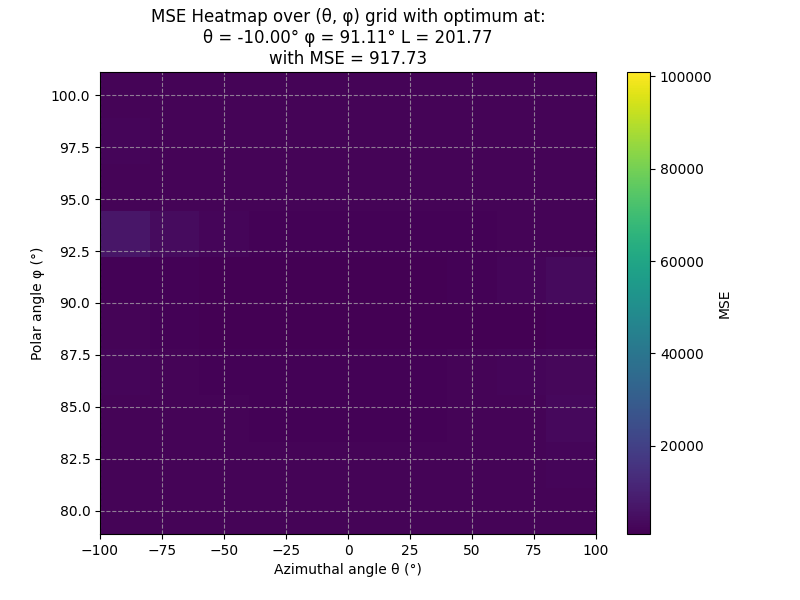

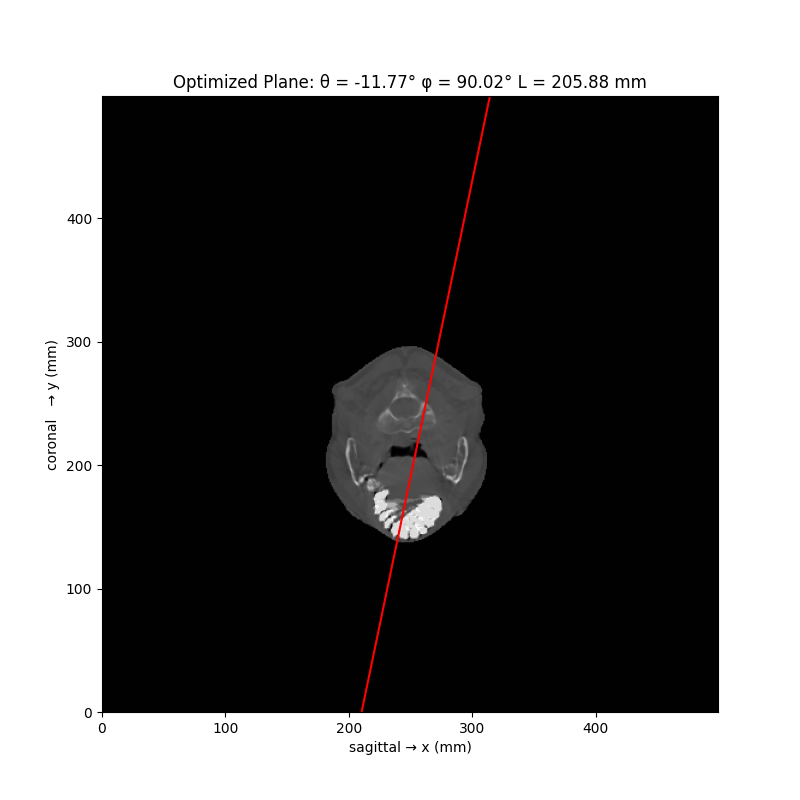

In [ ]:
%matplotlib widget
#%matplotlib inline

data_path = r"/home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean"

output_path = r"/home/loriskeller/Documents/Master Project/Results/12.05.25/Tester"
MSP_pipeline(data_path, output_path, structure_names=["Image", "GTVp", "Mandible", "Spinal Cord", "Body"], HU_range=[300, 5000])
